# Song Information Grabber

The goal is to grab information of the song that could possibly help the Neural Network with weights and etc...

By: 
- Andrew Angulo
- Daniel Ziabicki
- Liam Quinlan

In [ ]:
%pip install librosa

In [ ]:
import os
import pandas as pd
import numpy as np
#import scipy.io
import matplotlib.pyplot as plt

# from scipy.io import wavfile
from os.path import dirname, join as pjoin

---
# Grabbing The Song

In [ ]:
# Get the current working directory (where your notebook/script is running)
current_dir = os.getcwd()

# Build the path to the Test_Songs folder
data_dir = pjoin(current_dir, 'Test_Songs')

# Full path to the song
song_path = pjoin(data_dir, 'Lifestyle.wav')

c:\Users\ajang\OneDrive\Desktop\Music Classifier\Test_Songs\Lifestyle.wav


---
# Understanding the data within the Song file

Utilizing the documentation to understand the data from the example song file

[Librosa Documentation](https://librosa.org/doc/latest/index.html)

[I followed this guide](https://www.youtube.com/watch?v=Oa_d-zaUti8&list=PL-wATfeyAMNrtbkCNsLcpoAyBBRJZVlnf&index=11)

In [76]:
import librosa, librosa.display

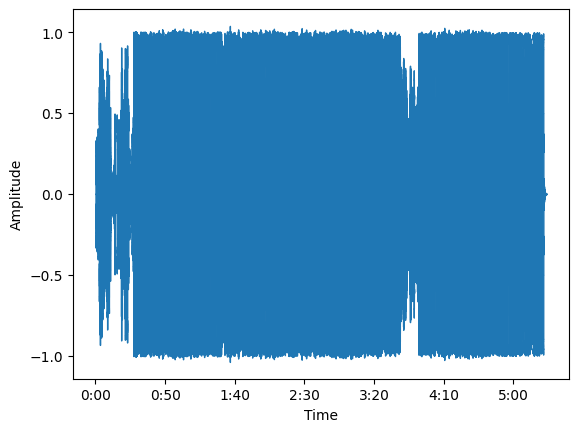

In [ ]:
audio_data, sample_rate = librosa.load(song_path, sr=22050)
librosa.display.waveshow(audio_data, sr=sample_rate)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

In [87]:
fft = np.fft.fft(audio_data)
magnitude = np.abs(fft)
frequency = np.linspace(0, sample_rate, len(magnitude))

left_frequency = frequency[:int(len(frequency)/2)]
left_magnitude = magnitude[:int(len(frequency)/2)]

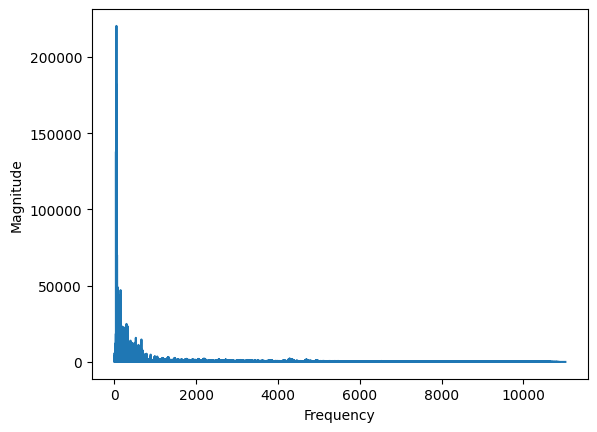

In [106]:
plt.plot(left_frequency, left_magnitude)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

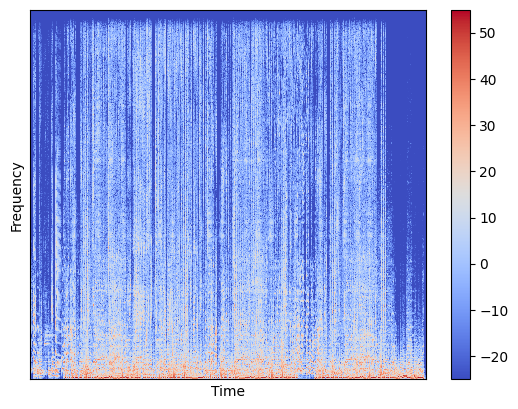

In [91]:
n_fft = 2048 # number of samples
hop_length = 512 # amount we shift each fft to the right


stft = librosa.core.stft(audio_data, hop_length = hop_length, n_fft = n_fft)

spectrogram = np.abs(stft)
log_spectrogram = librosa.amplitude_to_db(spectrogram)


librosa.display.specshow(log_spectrogram, sr = sample_rate, hop_length = hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

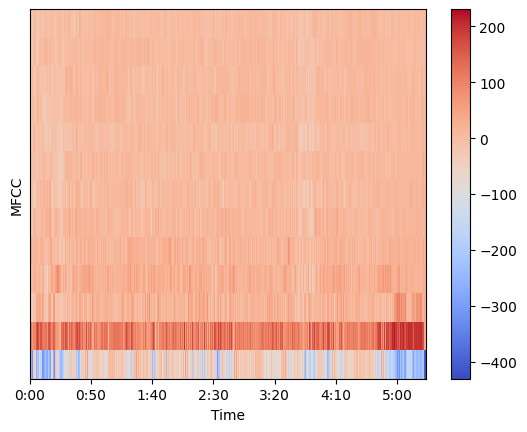

In [100]:
# MFCC
MFCCs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)

librosa.display.specshow(MFCCs, sr=sample_rate, hop_length=hop_length, x_axis='time')
plt.xlabel("Time")
plt.ylabel("MFCC")
plt.colorbar()
plt.show()
